In [1]:
from xgboost import XGBClassifier
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load data

In [2]:
from dataset import GetMedMNIST

d_size = 64

data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.detach().numpy()),
])

train_dataloader = GetMedMNIST(name='PathMNIST', split='train', size=d_size, hf=False, transform=data_transform)
test_dataloader = GetMedMNIST(name='PathMNIST', split='test', size=d_size, hf=False, transform=data_transform)

train_loader = DataLoader(train_dataloader, batch_size=len(train_dataloader.dataset), shuffle=False)
train_x, train_y = next(iter(train_loader))[0].reshape(-1, d_size**2), next(iter(train_loader))[1].detach().numpy()

test_loader = DataLoader(test_dataloader, batch_size=len(test_dataloader.dataset))
test_x, test_y = next(iter(test_loader))[0].reshape(-1, d_size**2), next(iter(test_loader))[1].detach().numpy()

100%|██████████| 1.07G/1.07G [00:30<00:00, 34.9MB/s]


# Train

In [3]:
model = XGBClassifier(n_estimators=200, objective='multi:softmax', num_class=train_dataloader.n_classes, device='cuda')

model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=9, ...)

In [4]:
y_true = test_y
y_pred = model.predict(test_x)

# Evaluation

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

def eval_model(labels, preds):
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', fmt='.0f')

    acc = accuracy_score(labels, preds)

    f1 = f1_score(labels, preds, average='weighted')

    class_report = classification_report(labels, preds)
    print(f'model accuracy: {acc*100:.2f}, f1 weighted: {f1:.4f}')
    print(class_report)

model accuracy: 63.30, f1 weighted: 0.6438
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1338
           1       0.94      1.00      0.96       847
           2       0.27      0.41      0.33       339
           3       0.86      0.79      0.83       634
           4       0.59      0.37      0.45      1035
           5       0.30      0.35      0.32       592
           6       0.66      0.69      0.68       741
           7       0.15      0.24      0.19       421
           8       0.64      0.75      0.69      1233

    accuracy                           0.63      7180
   macro avg       0.60      0.59      0.58      7180
weighted avg       0.67      0.63      0.64      7180



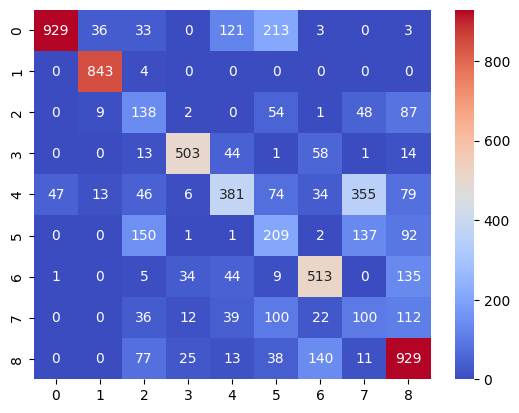

In [6]:
eval_model(y_true, y_pred)

ROC Score: 0.929


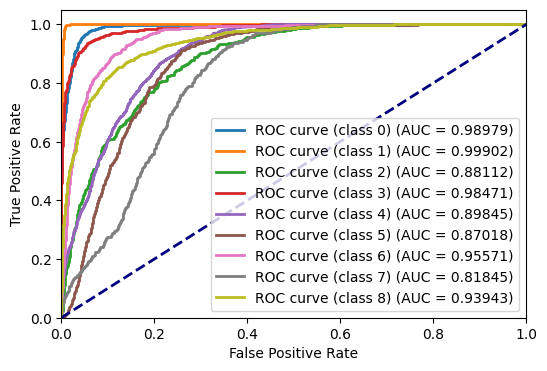

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

true_labels = test_y.ravel()
predictions = model.predict_proba(test_x)

roc_score = roc_auc_score(true_labels, predictions, multi_class='ovo', average='weighted')
print(f"ROC Score: {roc_score:.3f}")

num_classes = predictions.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [59]:
import numpy as np

label_idx = 1
idx = np.where(test_y == label_idx)[0]
sample_idx = 0

In [60]:
import shap
import numpy as np

explainer = shap.TreeExplainer(model)
sample = test_x[idx][sample_idx]
shap_values = explainer.shap_values(sample.reshape(1, -1)).transpose(2,0,1)
print(shap_values.shape)

(9, 1, 4096)


In [61]:
shap_matrix = np.array(shap_values[label_idx])

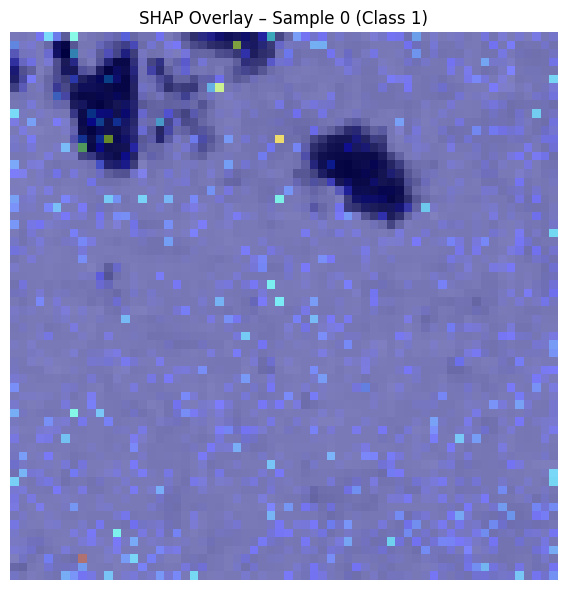

In [62]:
import matplotlib.pyplot as plt

shap_image = np.abs(shap_matrix[sample_idx].reshape(d_size, d_size))

plt.figure(figsize=(6, 6))
plt.imshow(sample.reshape(d_size, d_size), cmap='gray')
heatmap = plt.imshow(shap_image, cmap='jet', alpha=0.5)
plt.title(f'SHAP Overlay – Sample {sample_idx} (Class {label_idx})')
plt.axis('off')
plt.tight_layout()
plt.show()